In [26]:
%cd

/home/iit


In [27]:
# Check cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# Import RDKit

In [28]:
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import rdmolfiles
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG=True
except ImportError:
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
    exit()

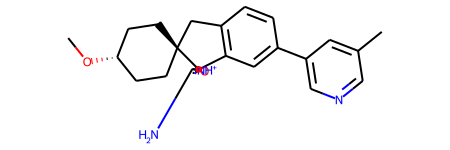

In [29]:
mol = Chem.MolFromSmiles('CO[C@@H]1CC[C@@]2(CC1)Cc1c([C@]32COC(=[NH+]3)N)cc(cc1)c1cncc(c1)C')
mol

# Import required packages

In [30]:
import os
import gc
import sys
import time
import json
import math
import random
import argparse
import itertools
import numpy as np
import mxnet as mx
import networkx as nx
from scipy import sparse
from mxnet.gluon import nn
from mxnet.autograd import Function
from mxnet.gluon.data import Dataset
from mxnet import gluon, autograd, nd
from mxnet.gluon.data import DataLoader
from abc import ABCMeta, abstractmethod
from mxnet.gluon.data.sampler import Sampler

# Initialize Hyperparameters

In [31]:
batch_size = 8   # training batch size
batch_size_test = 8   # test batch size
k = 5   # number of generation paths
p = 0.8   # randomness parameter alpha
F_e = 16    # initial hidden embedding size for each node in a graph
F_h = [32, 64, 128, 128, 256, 256]    # output sizes of each GCN layer
F_skip = 256    # size of skip connection layer
F_c = [512, ]   # hidden sizes of fully connected layers after graph convolution
Fh_policy = 128   # hidden size for policy layer
activation = 'relu'   # activation function
max_epochs = 10    # maximum number of epochs
patience = 10   # how many steps in past to check test loss for early stopping
lr = 1e-4   # initial learning rate
decay = 0.002    # initial weight decay
decay_step = 100    # perform weight decay after 100 steps
clip_grad = 3.0    # gradient clipping factor
summary_step = 200    # store model and training metrics after every 200 steps
N_rnn = 3   # number of layers used in GRUs
N_C = 6165   # size of pretrained protein embedding (DGGNP) or one hot encoding (Li et al.))
is_continuous = False   # load previous model or not
train_only = True   # train only mode or not, in train only mode validation is not done
ckpt_dir = 'DGGNP/outputs/logs/'   # logs directory

# Read Data

In [32]:
def read_data(file_name):
    smiles = []
    with open(file_name) as f:
        for line in f:
            smiles.append(line.strip())
    return smiles

In [33]:
t2t_data_train = '/home/iit/DGGNP/data/bindingdb/train_dataset/train_4_org_1004_122/d3_tr_dggnp.txt'
dataset_train = read_data(t2t_data_train)
if train_only == False:
    t2t_data_test = '/home/iit/DGGNP/data/bindingdb/test_dataset/test_4_org_1004_122/d3_va_dggnp.txt'
    dataset_test = read_data(t2t_data_test)

In [34]:
print(len(dataset_train))
print(type(dataset_train))
print(dataset_train[:5])
if train_only == False:
    print(len(dataset_test))
    print(type(dataset_test))
    print(dataset_test[:5])

143999
<class 'list'>
['CC(C)[C@@]1(NC(=O)[C@@H]2C=C3c4cccc5[nH]cc(c45)C[C@H]3N(C)C2)O[C@@]2(O)[C@@H]3CCCN3C(=O)[C@H](Cc3ccccc3)N2C1=O\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t

# Creating dataset iterable

In [35]:
class IterableDataset(Dataset):

    __metaclass__ = ABCMeta

    def __iter__(self):
        return (self[i] for i in range(len(self)))


class Lambda(IterableDataset):
    """
    Preprocessing fn
    """

    def __init__(self, dataset, fn=lambda _x: _x):
        random.seed(17)
        random.shuffle(dataset)
        self.dataset = dataset
        self.fn = fn

    def __getitem__(self, index):
        return self.fn(self.dataset[index])

    def __len__(self):
        return len(self.dataset)

# Creating mini-batches

In [36]:
class BalancedSampler(Sampler):

    def __init__(self, cost, batch_size):
        index = np.argsort(cost).tolist()
        chunk_size = int(float(len(cost))/batch_size)
        self.index = []
        for i in range(batch_size):
            self.index.append(index[i*chunk_size:(i + 1)*chunk_size])

    def _g(self):
        # shuffle data
        for index_i in self.index:
            random.shuffle(index_i)

        for batch_index in zip(*self.index):
            yield batch_index

    def __iter__(self):
        return self._g()

    def __len__(self):
        return len(self.index[0])

# Separating smiles and protein embedding

In [37]:
class Conditional(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def __call__(self, *args, **kwargs):
        raise NotImplementedError

class Delimited(Conditional):

    def __init__(self, d='\t'):
        self.d = d

    def __call__(self, line):
        line = line.strip('\n').strip('\r')
        line = line.split(self.d)

        smiles = line[0]
        c = np.array([float(c_i) for c_i in line[1:]], dtype=np.float32)

        return smiles, c

# Obtain all molecular properties

In [38]:
class MoleculeSpec(object):

    def __init__(self, file_name='DGGNP/data/atom_types.txt'):
        self.atom_types = []
        self.atom_symbols = []
        with open(file_name) as f:
            for line in f:
                atom_type_i = line.strip('\n').split(',')
                self.atom_types.append((atom_type_i[0], int(atom_type_i[1]), int(atom_type_i[2])))
                if atom_type_i[0] not in self.atom_symbols:
                    self.atom_symbols.append(atom_type_i[0])
        self.bond_orders = [Chem.BondType.AROMATIC,
                            Chem.BondType.SINGLE,
                            Chem.BondType.DOUBLE,
                            Chem.BondType.TRIPLE]
        self.max_iter = 120

    def get_atom_type(self, atom):
        atom_symbol = atom.GetSymbol()
        atom_charge = atom.GetFormalCharge()
        atom_hs = atom.GetNumExplicitHs()
        return self.atom_types.index((atom_symbol, atom_charge, atom_hs))

    def get_bond_type(self, bond):
        return self.bond_orders.index(bond.GetBondType())

    def index_to_atom(self, idx):
        atom_symbol, atom_charge, atom_hs = self.atom_types[idx]
        a = Chem.Atom(atom_symbol)
        a.SetFormalCharge(atom_charge)
        a.SetNumExplicitHs(atom_hs)
        return a

    def index_to_bond(self, mol, begin_id, end_id, idx):
        mol.AddBond(begin_id, end_id, self.bond_orders[idx])

    @property
    def num_atom_types(self):
        return len(self.atom_types)

    @property
    def num_bond_types(self):
        return len(self.bond_orders)

_mol_spec = None

def get_mol_spec():
    global _mol_spec
    if _mol_spec is None:
        _mol_spec = MoleculeSpec()
    return _mol_spec

# Utility functions for data preprocessing

In [39]:
def get_graph_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # build graph
    atom_types, atom_ranks, bonds, bond_types = [], [], [], []
    for a, r in zip(mol.GetAtoms(), Chem.CanonicalRankAtoms(mol)):
        atom_types.append(get_mol_spec().get_atom_type(a))
        atom_ranks.append(r)
    for b in mol.GetBonds():
        idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
        bonds.append([idx_1, idx_2])
        bond_types.append(bt)

    # build nx graph
    graph = nx.Graph()
    graph.add_nodes_from(range(len(atom_types)))
    graph.add_edges_from(bonds)

    return graph, atom_types, atom_ranks, bonds, bond_types


def get_graph_from_smiles_list(smiles_list):
    graph_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)

        # build graph
        atom_types, bonds, bond_types = [], [], []
        for a in mol.GetAtoms():
            atom_types.append(get_mol_spec().get_atom_type(a))
        for b in mol.GetBonds():
            idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
            bonds.append([idx_1, idx_2])
            bond_types.append(bt)

        X_0 = np.array(atom_types, dtype=np.int64)
        A_0 = np.concatenate([np.array(bonds, dtype=np.int64),
                              np.array(bond_types, dtype=np.int64)[:, np.newaxis]],
                             axis=1)
        graph_list.append([X_0, A_0])
    return graph_list


def traverse_graph(graph, atom_ranks, current_node=None, step_ids=None, p=0.9, log_p=0.0):
    if current_node is None:
        next_nodes = range(len(atom_ranks))
        step_ids = [-1, ] * len(next_nodes)
        next_node_ranks = atom_ranks
    else:
        next_nodes = graph.neighbors(current_node)  # get neighbor nodes
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes
        next_node_ranks = [atom_ranks[n] for n in next_nodes] # get ranks for neighbors
    next_nodes = [n for n, r in sorted(zip(next_nodes, next_node_ranks), key=lambda _x:_x[1])] # sort by rank

    # iterate through neighbors
    while len(next_nodes) > 0:
        if len(next_nodes)==1:
            next_node = next_nodes[0]
        elif random.random() >= (1 - p):
            next_node = next_nodes[0]
            log_p += np.log(p)
        else:
            next_node = next_nodes[random.randint(1, len(next_nodes) - 1)]
            log_p += np.log((1.0 - p) / (len(next_nodes) - 1))
        step_ids[next_node] = max(step_ids) + 1
        _, log_p = traverse_graph(graph, atom_ranks, next_node, step_ids, p, log_p)
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes

    return step_ids, log_p


def single_reorder(X_0, A_0, step_ids):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    step_ids = np.array(step_ids, dtype=np.int64)

    # sort by step_ids
    sorted_ids = np.argsort(step_ids)
    X_0 = X_0[sorted_ids]
    A_0[:, 0], A_0[:, 1] = step_ids[A_0[:, 0]], step_ids[A_0[:, 1]]
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    A_0 = A_0[np.lexsort([-min_b, max_b]), :]

    # separate append and connect
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    is_append = np.concatenate([np.array([True]), max_b[1:] > max_b[:-1]])
    A_0 = np.concatenate([np.where(is_append[:, np.newaxis],
                                 np.stack([min_b, max_b], axis=1),
                                 np.stack([max_b, min_b], axis=1)),
                        A_0[:, -1:]], axis=1)

    return X_0, A_0


def single_expand(X_0, A_0):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    # expand X
    is_append_iter = np.less(A_0[:, 0], A_0[:, 1]).astype(np.int64)
    NX = np.cumsum(np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1))
    shift = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    X_index = np.arange(NX.sum(), dtype=np.int64) - np.repeat(shift, NX)
    X = X_0[X_index]

    # expand A
    _, A_index = np.tril_indices(A_0.shape[0])
    A = A_0[A_index, :]
    NA = np.arange(A_0.shape[0] + 1)

    # get action
    # action_type, atom_type, bond_type, append_pos, connect_pos
    action_type = 1 - is_append_iter
    atom_type = np.where(action_type == 0, X_0[A_0[:, 1]], 0)
    bond_type = A_0[:, 2]
    append_pos = np.where(action_type == 0, A_0[:, 0], 0)
    connect_pos = np.where(action_type == 1, A_0[:, 1], 0)
    actions = np.stack([action_type, atom_type, bond_type, append_pos, connect_pos],
                       axis=1)
    last_action = [[2, 0, 0, 0, 0]]
    actions = np.append(actions, last_action, axis=0)

    action_0 = np.array([X_0[0]], dtype=np.int64)

    # }}}

    # {{{ Get mask
    last_atom_index = shift + NX - 1
    last_atom_mask = np.zeros_like(X)
    last_atom_mask[last_atom_index] = np.where(
        np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1) == 1,
        np.ones_like(last_atom_index),
        np.ones_like(last_atom_index) * 2)
    # }}}

    return action_0, X, NX, A, NA, actions, last_atom_mask


def get_d(A, X):
    _to_sparse = lambda _A, _X: sparse.coo_matrix((np.ones([_A.shape[0] * 2], dtype=np.int64),
                                                   (np.concatenate([_A[:, 0], _A[:, 1]], axis=0),
                                                    np.concatenate([_A[:, 1], _A[:, 0]], axis=0))),
                                                  shape=[_X.shape[0], ] * 2)
    A_sparse = _to_sparse(A, X)

    d2 = A_sparse * A_sparse
    d3 = d2 * A_sparse

    # get D_2
    D_2 = np.stack(d2.nonzero(), axis=1)
    D_2 = D_2[D_2[:, 0] < D_2[:, 1], :]

    # get D_3
    D_3 = np.stack(d3.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    # remove D_1 elements from D_3
    D_3_sparse = _to_sparse(D_3, X)
    D_3_sparse = D_3_sparse - D_3_sparse.multiply(A_sparse)
    D_3 = np.stack(D_3_sparse.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    return D_2, D_3


def merge_single_0(X_0, A_0, NX_0, NA_0):
    # shift_ids
    cumsum = np.cumsum(np.pad(NX_0, [[1, 0]], mode='constant')[:-1])
    A_0[:, :2] += np.stack([np.repeat(cumsum, NA_0), ] * 2, axis=1)

    # get D
    D_0_2, D_0_3 = get_d(A_0, X_0)

    # split A
    A_split = []
    for i in range(get_mol_spec().num_bond_types):
        A_i = A_0[A_0[:, 2] == i, :2]
        A_split.append(A_i)
    A_split.extend([D_0_2, D_0_3])
    A_0 = A_split

    # NX_rep
    NX_rep_0 = np.repeat(np.arange(NX_0.shape[0]), NX_0)

    return X_0, A_0, NX_0, NX_rep_0


def merge_single(X, A,
                 NX, NA,
                 mol_ids, rep_ids, iw_ids,
                 action_0, actions,
                 last_append_mask,
                 log_p):
    X, A, NX, NX_rep = merge_single_0(X, A, NX, NA)
    cumsum = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    actions[:, -2] += cumsum * (actions[:, 0] == 0)
    actions[:, -1] += cumsum * (actions[:, 0] == 1)
    mol_ids_rep = np.repeat(mol_ids, NX)
    rep_ids_rep = np.repeat(rep_ids, NX)

    return X, A,\
           mol_ids_rep, rep_ids_rep, iw_ids,\
           last_append_mask,\
           NX, NX_rep,\
           action_0, actions, \
           log_p

def process_single(smiles, k, p):
    graph, atom_types, atom_ranks, bonds, bond_types = get_graph_from_smiles(smiles)

    # original
    X_0 = np.array(atom_types, dtype=np.int64)
    A_0 = np.concatenate([np.array(bonds, dtype=np.int64),
                          np.array(bond_types, dtype=np.int64)[:, np.newaxis]],
                         axis=1)

    X, A = [], []
    NX, NA = [], []
    mol_ids, rep_ids, iw_ids = [], [], []
    action_0, actions = [], []
    last_append_mask = []
    log_p = []

    # sampling generation paths
    for i in range(k):
        step_ids_i, log_p_i = traverse_graph(graph, atom_ranks, p=p)
        X_i, A_i = single_reorder(X_0, A_0, step_ids_i)
        action_0_i, X_i, NX_i, A_i, NA_i, actions_i, last_atom_mask_i = single_expand(X_i, A_i)

        # appends
        X.append(X_i)
        A.append(A_i)
        NX.append(NX_i)
        NA.append(NA_i)
        action_0.append(action_0_i)
        actions.append(actions_i)
        last_append_mask.append(last_atom_mask_i)

        mol_ids.append(np.zeros_like(NX_i, dtype=np.int64))
        rep_ids.append(np.ones_like(NX_i, dtype=np.int64) * i)
        iw_ids.append(np.ones_like(NX_i, dtype=np.int64) * i)

        log_p.append(log_p_i)

    # concatenate
    X = np.concatenate(X, axis=0)
    A = np.concatenate(A, axis = 0)
    NX = np.concatenate(NX, axis = 0)
    NA = np.concatenate(NA, axis = 0)
    action_0 = np.concatenate(action_0, axis = 0)
    actions = np.concatenate(actions, axis = 0)
    last_append_mask = np.concatenate(last_append_mask, axis = 0)
    mol_ids = np.concatenate(mol_ids, axis = 0)
    rep_ids = np.concatenate(rep_ids, axis = 0)
    iw_ids = np.concatenate(iw_ids, axis = 0)
    log_p = np.array(log_p, dtype=np.float32)

    return X, A, NX, NA, mol_ids, rep_ids, iw_ids, action_0, actions, last_append_mask, log_p

# Loading data on GPU

In [40]:
class MolLoader(DataLoader):
    """Load graph based molecule representation from SMILES"""
    def __init__(self, dataset, batch_size=10, num_workers=0,
                 k=10, p=0.9, shuffle=False, sampler=None, batch_sampler=None):
        self.k = k
        self.p = p

        # batch_sampler, sampler and shuffle are mutually exclusive
        if batch_sampler is not None:
            super(MolLoader, self).__init__(dataset, batch_sampler=batch_sampler,
                                            num_workers=num_workers, batchify_fn=self._collate_fn)
        elif sampler is not None:
            super(MolLoader, self).__init__(dataset, sampler=sampler,
                                            num_workers=num_workers, batchify_fn=self._collate_fn,
                                            last_batch='rollover')
        else:
            super(MolLoader, self).__init__(dataset, batch_size, shuffle=shuffle,
                                            num_workers=num_workers, batchify_fn=self._collate_fn,
                                            last_batch='rollover')


    def _collate_fn(self, batch):
        # names = X, A,
        #         NX, NA,
        #         mol_ids, rep_ids, iw_ids,
        #         action_0, actions,
        #         last_append_mask,
        #         log_p

        shapes = [[0], [0, 3],
                  [0], [0],
                  [0], [0], [0],
                  [0], [0, 5],
                  [0],
                  [0]]
        dtypes = [np.int64, np.int64,
                  np.int64, np.int64,
                  np.int64, np.int64, np.int64,
                  np.int64, np.int64,
                  np.int64,
                  np.float32]

        _build = lambda: [np.zeros(shape=s, dtype=d) for s, d in zip(shapes, dtypes)]
        _append = lambda _r0, _r1: [np.concatenate([__r0, __r1], axis=0)
                                    for __r0, __r1 in zip(_r0, _r1)]

        X, A, \
        NX, NA, \
        mol_ids, rep_ids, iw_ids, \
        action_0, actions, \
        last_append_mask, \
        log_p = _build()


        for i, record_in in enumerate(batch):
            smiles = record_in

            X_i, A_i, \
            NX_i, NA_i, \
            mol_ids_i, rep_ids_i, iw_ids_i, \
            action_0_i, actions_i, \
            last_append_mask_i, log_p_i = process_single(smiles, self.k, self.p)

            if i != 0:
                mol_ids_i += mol_ids[-1] + 1
                iw_ids_i += iw_ids[-1] + 1

            X, A, \
            NX, NA, \
            mol_ids, rep_ids, iw_ids, \
            action_0, actions, \
            last_append_mask, \
            log_p = _append([X, A,
                             NX, NA,
                             mol_ids, rep_ids, iw_ids,
                             action_0, actions,
                             last_append_mask,
                             log_p],
                            [X_i, A_i,
                             NX_i, NA_i,
                             mol_ids_i, rep_ids_i, iw_ids_i,
                             action_0_i, actions_i,
                             last_append_mask_i,
                             log_p_i])

        X, A, \
        mol_ids_rep, rep_ids_rep, iw_ids, \
        last_append_mask, \
        NX, NX_rep, \
        action_0, actions, \
        log_p = merge_single(X, A,
                                   NX, NA,
                                   mol_ids, rep_ids, iw_ids,
                                   action_0, actions,
                                   last_append_mask,
                                   log_p)

        result_out = [X, A,
                      mol_ids_rep, rep_ids_rep, iw_ids,
                      last_append_mask,
                      NX, NX_rep,
                      action_0, actions,
                      log_p]

        return result_out

    @staticmethod
    def from_numpy_to_tensor(record):
        """Convert numpy to tensor and place it to a specific device"""
        [X, A,
         mol_ids_rep, rep_ids_rep, iw_ids,
         last_append_mask,
         NX, NX_rep,
         action_0, actions,
         log_p] = record

        X = nd.array(X, ctx=mx.gpu(), dtype='int64')
        A_sparse = []
        for A_i in A:
            if A_i.shape[0] == 0:
                A_sparse.append(None)
            else:
                # transpose may not be supported in gpu
                A_i = np.concatenate([A_i, A_i[:, [1, 0]]], axis=0)

                # construct csr matrix ...
                data = np.ones((A_i.shape[0], ), dtype=np.float32)
                row, col = A_i[:, 0], A_i[:, 1]
                A_sparse_i = nd.sparse.csr_matrix((data, (row, col)),
                                                  shape=tuple([int(X.shape[0]), ]*2),
                                                  ctx=mx.gpu(),
                                                  dtype='float32')

                # append to list
                A_sparse.append(A_sparse_i)

        batch_size, iw_size = (mol_ids_rep.max() + 1).item(), \
                              (rep_ids_rep.max() + 1).item()

        mol_ids_rep, rep_ids_rep, iw_ids, \
        last_append_mask, \
        NX, NX_rep, action_0, actions = [nd.array(_x, ctx=mx.gpu(), dtype='int64')
                                         for _x in [mol_ids_rep, rep_ids_rep, iw_ids,
                                                    last_append_mask,
                                                    NX, NX_rep, action_0, actions]]

        log_p = nd.array(log_p, ctx=mx.gpu(), dtype='float32')

        record = [X, A_sparse, iw_ids, last_append_mask,
                  NX, NX_rep, action_0, actions, log_p,
                  batch_size, iw_size]


        return record


class MolRNNLoader(MolLoader):

    def _collate_fn(self, batch):
        result_out = super(MolRNNLoader, self)._collate_fn(batch)

        # things ready for rnn
        mol_list = [Chem.MolFromSmiles(batch_i) for batch_i in batch]
        # preparing mapping
        graph_to_rnn = np.zeros((len(batch), self.k, get_mol_spec().max_iter), dtype=np.int64)
        rnn_to_graph = []
        cum_sum = 0
        for i, mol_i in enumerate(mol_list):
            num_iter = mol_i.GetNumBonds() + 1
            for k in range(self.k):
                graph_to_rnn[i, k, :num_iter] = (np.arange(num_iter) + cum_sum)

                rnn_to_graph_0 = np.ones([num_iter,], dtype=np.int64) * i
                rnn_to_graph_1 = np.ones_like(rnn_to_graph_0) * k
                rnn_to_graph_2 = np.arange(num_iter)
                rnn_to_graph.append(np.stack([rnn_to_graph_0, rnn_to_graph_1, rnn_to_graph_2], axis=0))

                cum_sum += num_iter
        rnn_to_graph = np.concatenate(rnn_to_graph, axis=1)
        NX_cum = np.cumsum(result_out[6])

        result_out = result_out + [graph_to_rnn, rnn_to_graph, NX_cum]

        return result_out

    @staticmethod
    def from_numpy_to_tensor(record):
        [X, A,
         mol_ids_rep, rep_ids_rep, iw_ids,
         last_append_mask,
         NX, NX_rep,
         action_0, actions,
         log_p,
         graph_to_rnn, rnn_to_graph, NX_cum] = record

        output = MolLoader.from_numpy_to_tensor([X, A,
                                                 mol_ids_rep, rep_ids_rep, iw_ids,
                                                 last_append_mask,
                                                 NX, NX_rep,
                                                 action_0, actions,
                                                 log_p])

        graph_to_rnn, rnn_to_graph, NX_cum =\
            nd.array(graph_to_rnn, ctx=mx.gpu(), dtype='int64'),\
            nd.array(rnn_to_graph, ctx=mx.gpu(), dtype='int64'), \
            nd.array(NX_cum, ctx=mx.gpu(), dtype='int64')

        output = output + [graph_to_rnn, rnn_to_graph, NX_cum]

        return output
    
class CMolRNNLoader(MolRNNLoader):

    def __init__(self, dataset, batch_size=10, num_workers=0,
                 k=10, p=0.9, shuffle=False, sampler=None, batch_sampler=None,
                 conditional=None):
        if conditional is None:
            raise ValueError('Conditional function is not set, '
                             'use unconditional version instead')
        if not callable(conditional):
            raise TypeError('Provided condition is not callable')

        self.conditional = conditional

        super(CMolRNNLoader, self).__init__(dataset, batch_size, num_workers,
                                            k, p, shuffle, sampler, batch_sampler)

    def _collate_fn(self, batch):
        smiles_list, c = [], []
        for record_i in batch:
            smiles_i, c_i = self.conditional(record_i)
            smiles_list.append(smiles_i)
            c.append(c_i)
        c = np.stack(c, axis=0)

        output = super(CMolRNNLoader, self)._collate_fn(smiles_list)
        output.append(c)

        return output

    @staticmethod
    def from_numpy_to_tensor(record):
        [X, A,
         mol_ids_rep, rep_ids_rep, iw_ids,
         last_append_mask,
         NX, NX_rep,
         action_0, actions,
         log_p,
         graph_to_rnn, rnn_to_graph, NX_cum,
         c] = record

        output = MolRNNLoader.from_numpy_to_tensor([X, A,
                                                    mol_ids_rep, rep_ids_rep, iw_ids,
                                                    last_append_mask,
                                                    NX, NX_rep,
                                                    action_0, actions,
                                                    log_p,
                                                    graph_to_rnn, rnn_to_graph, NX_cum])
        ids = nd.array(mol_ids_rep, ctx=mx.gpu(), dtype='int64')

        c = nd.array(c, ctx=mx.gpu(), dtype='float32')

        output = output + [c, ids]

        return output

# Defining graph convolution and other functions

In [41]:
class GraphConvFn(Function):

    def __init__(self, A):
        self.A = A # type: nd.sparse.CSRNDArray
        self.A_T = self.A # assume symmetric
        super(GraphConvFn, self).__init__()

    def forward(self, X):
        if self.A is not None:
            if len(X.shape) > 2:
                X_resized = X.reshape((X.shape[0], -1))
                output = nd.sparse.dot(self.A, X_resized)
                output = output.reshape([-1, ] + [X.shape[i] for i in range(1, len(X.shape))])
            else:
                output = nd.sparse.dot(self.A, X)
            return output
        else:
            return nd.zeros_like(X)

    def backward(self, grad_output):

        if self.A is not None:
            if len(grad_output.shape) > 2:
                grad_output_resized = grad_output.reshape((grad_output.shape[0], -1))
                grad_input = nd.sparse.dot(self.A_T, grad_output_resized)
                grad_input = grad_input.reshape([-1] + [grad_output.shape[i]
                                                        for i in range(1, len(grad_output.shape))])
            else:
                grad_input = nd.sparse.dot(self.A_T, grad_output)
            return grad_input
        else:
            return nd.zeros_like(grad_output)


class EfficientGraphConvFn(Function):
    """Save memory by re-computation"""

    def __init__(self, A_list):
        self.A_list = A_list
        super(EfficientGraphConvFn, self).__init__()

    def forward(self, X, W):
        X_list = [X]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)
        self.save_for_backward(X, W)

        return nd.dot(X_out, W)

    def backward(self, grad_output):
        X, W = self.saved_tensors

        # recompute X_out
        X_list = [X, ]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)

        grad_W = nd.dot(X_out.T, grad_output)

        grad_X_out = nd.dot(grad_output, W.T)
        grad_X_out_list = nd.split(grad_X_out, num_outputs=len(self.A_list) + 1)


        grad_X = [grad_X_out_list[0], ]
        for A, grad_X_out in zip(self.A_list, grad_X_out_list[1:]):
            if A is not None:
                grad_X.append(nd.sparse.dot(A, grad_X_out))
            else:
                grad_X.append(nd.zeros_like(grad_X_out))

        grad_X = sum(grad_X)

        return grad_X, grad_W


class SegmentSumFn(GraphConvFn):

    def __init__(self, idx, num_seg):
        # build A
        # construct coo
        data = nd.ones(idx.shape[0], ctx=idx.context, dtype='int64')
        row, col = idx, nd.arange(idx.shape[0], ctx=idx.context, dtype='int64')
        shape = (num_seg, int(idx.shape[0]))
        sparse = nd.sparse.csr_matrix((data, (row, col)), shape=shape,
                                      ctx=idx.context, dtype='float32')
        super(SegmentSumFn, self).__init__(sparse)

        sparse = nd.sparse.csr_matrix((data, (col, row)), shape=(shape[1], shape[0]),
                                      ctx=idx.context, dtype='float32')
        self.A_T = sparse


def squeeze(input, axis):
    assert input.shape[axis] == 1

    new_shape = list(input.shape)
    del new_shape[axis]

    return input.reshape(new_shape)


def unsqueeze(input, axis):
    return nd.expand_dims(input, axis=axis)


def logsumexp(inputs, axis=None, keepdims=False):
    """Numerically stable logsumexp.
    Args:
        inputs: A Variable with any shape.
        axis: An integer.
        keepdims: A boolean.
    Returns:
        Equivalent of log(sum(exp(inputs), dim=dim, keepdim=keepdim)).
    Adopted from: https://github.com/pytorch/pytorch/issues/2591
    """
    # For a 1-D array x (any array along a single dimension),
    # log sum exp(x) = s + log sum exp(x - s)
    # with s = max(x) being a common choice.
    if axis is None:
        inputs = inputs.reshape([-1])
        axis = 0
    s = nd.max(inputs, axis=axis, keepdims=True)
    outputs = s + (inputs - s).exp().sum(axis=axis, keepdims=True).log()
    if not keepdims:
        outputs = nd.sum(outputs, axis=axis, keepdims=False)
    return outputs


def get_activation(name):
    activation_dict = {
        'relu':nd.relu,
        'tanh':nd.tanh
    }
    return activation_dict[name]

# Defining neural networks

In [42]:
class Linear_BN(nn.Sequential):
    def __init__(self, F_in, F_out):
        super(Linear_BN, self).__init__()
        self.add(nn.Dense(F_out, in_units=F_in, use_bias=False))
        self.add(BatchNorm(in_channels=F_out))


class GraphConv(nn.Block):

    def __init__(self, Fin, Fout, D):
        super(GraphConv, self).__init__()

        # model settings
        self.Fin = Fin
        self.Fout = Fout
        self.D = D

        # model parameters
        self.W = self.params.get('w', shape=(self.Fin * (self.D + 1), self.Fout),
                                 init=None, allow_deferred_init=False)

    def forward(self, X, A_list):
        try:
            assert len(A_list) == self.D
        except AssertionError as e:
            print(self.D, len(A_list))
            raise e
        return EfficientGraphConvFn(A_list)(X, self.W.data(X.context))


class Policy(nn.Block):

    def __init__(self, F_in, F_h, N_A, N_B, k=1):
        super(Policy, self).__init__()
        self.F_in = F_in # number of input features for each atom
        self.F_h = F_h # number of context variables
        self.N_A = N_A # number of atom types
        self.N_B = N_B # number of bond types
        self.k = k # number of softmax used in the mixture


        with self.name_scope():
            self.linear_h = Linear_BN(F_in * 2, self.F_h * k)
            self.linear_h_t = Linear_BN(F_in, self.F_h * k)

            self.linear_x = nn.Dense(self.N_B + self.N_B*self.N_A, in_units=self.F_h)
            self.linear_x_t = nn.Dense(1, in_units=self.F_h)

            if self.k > 1:
                self.linear_pi = nn.Dense(self.k, in_units=self.F_in)
            else:
                self.linear_pi = None

    def forward(self, X, NX, NX_rep, X_end=None):
        # segment mean for X
        if X_end is None:
            X_end = SegmentSumFn(NX_rep, NX.shape[0])(X)/nd.cast(fn.unsqueeze(NX, 1), 'float32')
        X = nd.concat(X, X_end[NX_rep, :], dim=1)

        X_h = nd.relu(self.linear_h(X)).reshape([-1, self.F_h])
        X_h_end = nd.relu(self.linear_h_t(X_end)).reshape([-1, self.F_h])

        X_x = nd.exp(self.linear_x(X_h)).reshape([-1, self.k, self.N_B + self.N_B*self.N_A])
        X_x_end = nd.exp(self.linear_x_t(X_h_end)).reshape([-1, self.k, 1])

        X_sum = nd.sum(SegmentSumFn(NX_rep, NX.shape[0])(X_x), -1, keepdims=True) + X_x_end
        X_sum_gathered = X_sum[NX_rep, :, :]

        X_softmax = X_x / X_sum_gathered
        X_softmax_end = X_x_end/ X_sum

        if self.k > 1:
            pi = unsqueeze(nd.softmax(self.linear_pi(X_end), axis=1), -1)
            pi_gathered = pi[NX_rep, :, :]

            X_softmax = nd.sum(X_softmax * pi_gathered, axis=1)
            X_softmax_end = nd.sum(X_softmax_end * pi, axis=1)
        else:
            X_softmax = squeeze(X_softmax, 1)
            X_softmax_end = squeeze(X_softmax_end, 1)

        # generate output probabilities
        connect, append = X_softmax[:, :self.N_B], X_softmax[:, self.N_B:]
        append = append.reshape([-1, self.N_A, self.N_B])
        end = squeeze(X_softmax_end, -1)

        return append, connect, end


class BatchNorm(nn.Block):

    def __init__(self, in_channels, momentum=0.9, eps=1e-5):
        super(BatchNorm, self).__init__()
        self.F = in_channels

        self.bn_weight = self.params.get('bn_weight', shape=(self.F,), init=mx.init.One(),
                                         allow_deferred_init=False)
        self.bn_bias = self.params.get('bn_bias', shape=(self.F,), init=mx.init.Zero(),
                                       allow_deferred_init=False)

        self.running_mean = self.params.get('running_mean', grad_req='null',
                                            shape=(self.F,),
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False,
                                            differentiable=False)
        self.running_var = self.params.get('running_var', grad_req='null',
                                           shape=(self.F,),
                                           init=mx.init.One(),
                                           allow_deferred_init=False,
                                           differentiable=False)
        self.momentum = momentum
        self.eps = eps

    def forward(self, x):
        if autograd.is_training():
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=False)
        else:
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=True)

# Building generative network

In [43]:
class MoleculeGenerator(nn.Block):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 *args, **kwargs):
        super(MoleculeGenerator, self).__init__()
        self.N_A = N_A
        self.N_B = N_B
        self.D = D
        self.F_e = F_e
        self.F_skip = F_skip
        self.F_c = list(F_c) if isinstance(F_c, tuple) else F_c
        self.Fh_policy = Fh_policy
        self.activation = get_activation(activation)

        with self.name_scope():
            # embeddings
            self.embedding_atom = nn.Embedding(self.N_A, self.F_e)
            self.embedding_mask = nn.Embedding(3, self.F_e)

            # graph conv
            self._build_graph_conv(*args, **kwargs)

            # fully connected
            self.dense = nn.Sequential()
            for i, (f_in, f_out) in enumerate(zip([self.F_skip, ] + self.F_c[:-1], self.F_c)):
                self.dense.add(Linear_BN(f_in, f_out))

            # policy
            self.policy_0 = self.params.get('policy_0', shape=[self.N_A, ],
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False)
            self.policy_h = Policy(self.F_c[-1], self.Fh_policy, self.N_A, self.N_B)

        self.mode = 'loss'

    @abstractmethod
    def _build_graph_conv(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def _graph_conv_forward(self, X, A):
        raise NotImplementedError

    def _policy_0(self, ctx):
        policy_0 = nd.exp(self.policy_0.data(ctx))
        policy_0 = policy_0/policy_0.sum()
        return policy_0

    def _policy(self, X, A, NX, NX_rep, last_append_mask):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep)

        return append, connect, end

    def _likelihood(self, init, append, connect, end,
                    action_0, actions, iw_ids, log_p_sigma,
                    batch_size, iw_size):

        # decompose action:
        action_type, node_type, edge_type, append_pos, connect_pos = \
            actions[:, 0], actions[:, 1], actions[:, 2], actions[:, 3], actions[:, 4]
        _log_mask = lambda _x, _mask: _mask * nd.log(_x + 1e-10) + (1- _mask) * nd.zeros_like(_x)

        # init
        init = init.reshape([batch_size * iw_size, self.N_A])
        index = nd.stack(nd.arange(action_0.shape[0], ctx=action_0.context, dtype='int64'), action_0, axis=0)
        loss_init = nd.log(nd.gather_nd(init, index) + 1e-10)

        # end
        loss_end = _log_mask(end, nd.cast(action_type == 2, 'float32'))

        # append
        index = nd.stack(append_pos, node_type, edge_type, axis=0)
        loss_append = _log_mask(nd.gather_nd(append, index), nd.cast(action_type == 0, 'float32'))

        # connect
        index = nd.stack(connect_pos, edge_type, axis=0)
        loss_connect = _log_mask(nd.gather_nd(connect, index), nd.cast(action_type == 1, 'float32'))

        # sum up results
        log_p_x = loss_end + loss_append + loss_connect
        log_p_x = squeeze(SegmentSumFn(iw_ids, batch_size*iw_size)(unsqueeze(log_p_x, -1)), -1)
        log_p_x = log_p_x + loss_init

        # reshape
        log_p_x = log_p_x.reshape([batch_size, iw_size])
        log_p_sigma = log_p_sigma.reshape([batch_size, iw_size])
        l = log_p_x - log_p_sigma
        l = logsumexp(l, axis=1) - math.log(float(iw_size))
        return l

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask = input
            return self._policy(X, A, NX, NX_rep, last_append_mask)


class MoleculeGenerator_RNN(MoleculeGenerator):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 N_rnn, *args, **kwargs):
        super(MoleculeGenerator_RNN, self).__init__(N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                                                    *args, **kwargs)
        self.N_rnn = N_rnn

        with self.name_scope():
            self.rnn = gluon.rnn.GRU(hidden_size=self.F_c[-1],
                                     num_layers=self.N_rnn,
                                     layout='NTC', input_size=self.F_c[-1] * 2)

    def _rnn_train(self, X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum):
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum-1)
        X = nd.concat(X_avg, X_curr, dim=1)

        # rnn
        X = nd.take(X, indices=graph_to_rnn) # batch_size, iw_size, length, num_features
        batch_size, iw_size, length, num_features = X.shape
        X = X.reshape([batch_size*iw_size, length, num_features])
        X = self.rnn(X)

        X = X.reshape([batch_size, iw_size, length, -1])
        X = nd.gather_nd(X, indices=rnn_to_graph)

        return X

    def _rnn_test(self, X, NX, NX_rep, NX_cum, h):
        # note: one partition for one molecule
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum - 1)
        X = nd.concat(X_avg, X_curr, dim=1) # size: [NX, F_in * 2]

        # rnn
        X = unsqueeze(X, axis=1)
        X, h = self.rnn(X, h)

        X = squeeze(X, axis=1)
        return X, h

    def _policy(self, X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol = self._rnn_train(X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end

    def _decode_step(self, X, A, NX, NX_rep, last_append_mask, NX_cum, h):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol, h = self._rnn_test(X, NX, NX_rep, NX_cum, h)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end, h

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size, \
            graph_to_rnn, rnn_to_graph, NX_cum = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask, NX_cum, h = input
            return self._decode_step(X, A, NX, NX_rep, last_append_mask, NX_cum, h)
        else:
            raise ValueError
            
class _TwoLayerDense(nn.Block):

    def __init__(self, input_size, hidden_size, output_size):
        super(_TwoLayerDense, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size

        with self.name_scope():
            # config 1
            self.input = nn.Dense(self.hidden_size, use_bias=False, in_units=self.input_size)
            self.bn_input = BatchNorm(in_channels=self.hidden_size)
            self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.hidden_size)
            
            # config 2
            #self.bn_input = BatchNorm(in_channels=self.input_size)
            #self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.input_size)
            
            # config 3
            #self.input1 = nn.Dense(self.hidden_size, use_bias=False, in_units=self.input_size)
            #self.bn_input1 = BatchNorm(in_channels=self.hidden_size)
            #self.input2 = nn.Dense(self.hidden_size, use_bias=False, in_units=self.hidden_size)
            #self.bn_input2 = BatchNorm(in_channels=self.hidden_size)
            #self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.hidden_size)

    def forward(self, c):
        # config 1
        return nd.softmax(self.output(nd.relu(self.bn_input(self.input(c)))), axis=-1)
        
        # config 2
        #return nd.softmax(self.output(nd.relu(self.bn_input(c))), axis=-1)
    
        # config 3
        #return nd.softmax(self.output(nd.relu(self.bn_input2(self.input2(nd.relu(self.bn_input1(self.input1(c))))))), axis=-1)


class CMoleculeGenerator_RNN(MoleculeGenerator_RNN):
    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, N_C, D,
                 F_e, F_skip, F_c, Fh_policy,
                 activation, N_rnn,
                 *args, **kwargs):
        self.N_C = N_C # number of conditional variables
        super(CMoleculeGenerator_RNN, self).__init__(N_A, N_B, D,
                                                     F_e, F_skip, F_c, Fh_policy,
                                                     activation, N_rnn,
                                                     *args, **kwargs)
        with self.name_scope():
            self.dense_policy_0 = _TwoLayerDense(self.N_C, self.N_A * 3, self.N_A)

    @abstractmethod
    def _graph_conv_forward(self, X, A, c, ids):
        raise NotImplementedError

    def _policy_0(self, c):
        return self.dense_policy_0(c) + 0.0 * self.policy_0.data(c.context)

    def _policy(self, X, A, NX, NX_rep, last_append_mask,
                graph_to_rnn, rnn_to_graph, NX_cum,
                c, ids):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A, c, ids)

        # linear
        X = self.dense(X)

        # rnn
        X_mol = self._rnn_train(X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end

    def _decode_step(self, X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A, c, ids)

        # linear
        X = self.dense(X)

        # rnn
        X_mol, h = self._rnn_test(X, NX, NX_rep, NX_cum, h)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end, h


    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size, \
            graph_to_rnn, rnn_to_graph, NX_cum, \
            c, ids = input

            init = nd.tile(unsqueeze(self._policy_0(c), axis=1), [1, iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask,
                                                graph_to_rnn, rnn_to_graph, NX_cum,
                                                c, ids)
            l = self._likelihood(init, append, connect, end,
                                 action_0, actions, iw_ids, log_p,
                                 batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(*input)
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids = input
            return self._decode_step(X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids)
        else:
            raise ValueError

class CVanillaMolGen_RNN(CMoleculeGenerator_RNN):

    def __init__(self, N_A, N_B, N_C, D,
                 F_e, F_h, F_skip, F_c, Fh_policy,
                 activation, N_rnn, rename=False):
        self.rename = rename
        super(CVanillaMolGen_RNN, self).__init__(N_A, N_B, N_C, D,
                                                 F_e, F_skip, F_c, Fh_policy,
                                                 activation, N_rnn,
                                                 F_h)

    def _build_graph_conv(self, F_h):
        self.F_h = list(F_h) if isinstance(F_h, tuple) else F_h
        self.conv, self.bn = [], []
        for i, (f_in, f_out) in enumerate(zip([self.F_e] + self.F_h[:-1], self.F_h)):
            conv = GraphConv(f_in, f_out, self.N_B + self.D)
            self.conv.append(conv)
            self.register_child(conv)

            if i != 0:
                bn = BatchNorm(in_channels=f_in)
                self.register_child(bn)
            else:
                bn = None
            self.bn.append(bn)

        self.bn_skip = BatchNorm(in_channels=sum(self.F_h))
        self.linear_skip = Linear_BN(sum(self.F_h), self.F_skip)

        # projectors for conditional variable (protein embedding)
        self.linear_c = []
        for i, f_out in enumerate(self.F_h):
            if self.rename:
                linear_c = nn.Dense(f_out, use_bias=False, in_units=self.N_C, prefix='cond_{}'.format(i))
            else:
                linear_c = nn.Dense(f_out, use_bias=False, in_units=self.N_C)
            self.register_child(linear_c)
            self.linear_c.append(linear_c)

    def _graph_conv_forward(self, X, A, c, ids):
        X_out = [X]
        for conv, bn, linear_c in zip(self.conv, self.bn, self.linear_c):
            X = X_out[-1]
            if bn is not None:
                X_out.append(conv(self.activation(bn(X)), A) + linear_c(c)[ids, :])
            else:
                X_out.append(conv(X, A) + linear_c(c)[ids, :])
        X_out = nd.concat(*X_out[1:], dim=1)
        return self.activation(self.linear_skip(self.activation(self.bn_skip(X_out))))

In [44]:
# Early Stopping Implementation
class EarlyStopping(object):
    
    def __init__(self, patience=5, delta=1e-2, less_is_better=True):

        self.patience = patience
        self.delta = delta
        self.less_is_better = less_is_better
        self.best = math.inf if less_is_better else -math.inf
        self.counter = 0

    def update(self, loss):
        if self.best is None:
            self.best = loss
            return

        if self.less_is_better:
            # Best loss updated.
            if loss < self.best - self.delta:
                self.best = loss
                self.counter = 0
            else:
                self.counter += 1
        else:
            # Best loss updated.
            if loss > self.best + self.delta:
                self.best = loss
                self.counter = 0
            else:
                self.counter += 1

    def step(self, loss):
        self.update(loss)

        # Return True if the counter exceeded patience.
        return self.counter >= self.patience

    def get_best_score(self):
        return self.best

# Loading and preprocessing the dataset

In [45]:
if all([os.path.isfile(os.path.join(ckpt_dir, _n)) for _n in ['log.out', 'ckpt.params', 'trainer.status']]):
    is_continuous = True
else:
    is_continuous = False

cond = Delimited()
    
if train_only:
    dataset = Lambda(dataset_train, lambda _x: _x.strip('\n').strip('\r'))

    # get sampler and loader for training set
    sampler_train = BalancedSampler(cost=[len(l.split('\t')[0]) for l in dataset], batch_size=batch_size)
    loader_train = CMolRNNLoader(dataset, batch_sampler=sampler_train, num_workers=num_workers,
                                      k=k, p=p, conditional=cond)

    loader_test = []

else:
    if all([os.path.isfile(os.path.join(ckpt_dir, _n)) for _n in ['log.out', 'ckpt.params', 'trainer.status']]):
        is_continuous = True
    else:
        is_continuous = False

    db_train = Lambda(dataset_train, lambda _x: _x.strip('\n').strip('\r'))
    # get sampler and loader for training set
    sampler_train = BalancedSampler(cost=[len(l.split('\t')[0]) for l in db_train], batch_size=batch_size)
    loader_train = CMolRNNLoader(db_train, batch_sampler=sampler_train, num_workers=num_workers,
                                      k=k, p=p, conditional=cond)
    
    db_test = Lambda(dataset_test, lambda _x: _x.strip('\n').strip('\r'))
    # get sampler and loader for test set
    sampler_test = BalancedSampler(cost=[len(l.split('\t')[0]) for l in db_test], batch_size=batch_size_test)
    loader_test = CMolRNNLoader(db_test, batch_sampler=sampler_test, num_workers=num_workers,
                                      k=k, p=p, conditional=cond)

# get iterator
it_train, it_test = iter(loader_train), iter(loader_test)

# Construcing the model and initializing the parameters

In [47]:
# build model
if not is_continuous:
    configs = {'N_C': N_C,
               'F_e': F_e,
               'F_h': F_h,
               'F_skip': F_skip,
               'F_c': F_c,
               'Fh_policy': Fh_policy,
               'activation': activation,
               'rename': True,
               'N_rnn': N_rnn}
    with open(os.path.join(ckpt_dir, 'configs.json'), 'w') as f:
        json.dump(configs, f)
else:
    with open(os.path.join(ckpt_dir, 'configs.json')) as f:
        configs = json.load(f)

model = CVanillaMolGen_RNN(get_mol_spec().num_atom_types, get_mol_spec().num_bond_types, D=2, **configs)

ctx = mx.gpu()
model.collect_params().initialize(mx.init.Xavier(), force_reinit=True, ctx=ctx)
if not is_continuous:
    if cond_type == 'kinase':
        model.load_parameters(os.path.join(ckpt_dir, 'ckpt.params'), ctx=ctx, allow_missing=True)
else:
    model.load_parameters(os.path.join(ckpt_dir, 'ckpt.params'), ctx=ctx)

# construct optimizer
opt = mx.optimizer.Adam(learning_rate=lr, clip_gradient=clip_grad)
trainer = gluon.Trainer(model.collect_params(), opt)
if is_continuous:
    trainer.load_states(os.path.join(ckpt_dir, 'trainer.status'))

# Training the model

In [48]:
if not is_continuous:
    t0 = time.time()
    global_counter = 0
else:
    with open(os.path.join(ckpt_dir, 'log.out')) as f:
        records = f.readlines()
        if records[-1] != 'Training finished\n':
            final_record = records[-1]
        else:
            final_record = records[-2]
    count, t_final = int(final_record.split('\t')[0]), float(final_record.split('\t')[1])
    t0 = time.time() - t_final * 60
    global_counter = count

epoch_no = 1
break_train_loop = False
early_stopping = EarlyStopping(patience=patience, delta=1e-2, less_is_better=True)

with open(os.path.join(ckpt_dir, 'log.out'),
          mode='w' if not is_continuous else 'a') as f:
    if not is_continuous:
        f.write('Training started...\n')
        f.write('step\ttime(m)\tloss\tlr\n')
    while True:
        global_counter += 1
        eval_now = False
        try:
            inputs = next(it_train)
        except StopIteration:
            eval_now = True
            print('Epoch {} complete.'.format(epoch_no))
            f.write('\nEpoch {} complete.\n'.format(epoch_no))
            epoch_no += 1
            it_train = iter(loader_train)
            inputs = next(it_train)

        # move to gpu
        inputs = CMolRNNLoader.from_numpy_to_tensor(inputs)

        with autograd.record():
            loss = [(model(*inputs)).as_in_context(mx.gpu())]
            loss = sum(loss)
            loss.backward()

        nd.waitall()
        gc.collect()

        trainer.step(batch_size=1, ignore_stale_grad=True)

        if global_counter % decay_step == 0:
            trainer.set_learning_rate(trainer.learning_rate * (1.0 - decay))

        if global_counter % summary_step == 0:
            model.save_parameters(os.path.join(ckpt_dir, 'ckpt.params'))
            trainer.save_states(os.path.join(ckpt_dir, 'trainer.status'))
            
            print('Training loss = ', (sum(loss)).asnumpy().item())
            f.write('{}\t{:.2f}\t{:.4f}\t{:.8f}\n'.format(global_counter, float(time.time() - t0) / 60, (sum(loss)).asnumpy().item(),
                                              trainer.learning_rate))
            f.flush()

            print('{} iterations done!'.format(global_counter))
            
        if eval_now:
            if train_only:
                loss = (sum(loss)).asnumpy().item()
            else:
                del loss, inputs
                gc.collect()

                loss = []
                while True:
                    try:
                        inputs = next(it_test)
                        with autograd.predict_mode():
                            # move to gpu
                            inputs = CMolRNNLoader.from_numpy_to_tensor(inputs)
                            loss.append(sum([(model(*inputs)).as_in_context(mx.gpu())]))
                    except StopIteration:
                        loss = (sum(loss)/len(loss)).asnumpy().item()
                        print('Validation loss = ', loss)
                        f.write('\nValidation loss: {}\n\n'.format(loss))
                        stop = early_stopping.step(loss)
                        if stop:
                            best_score = early_stopping.get_best_score()
                            print(f'Early stopping! Best validation loss: {best_score}')
                            f.write(f'\n\nEarly stopping! Best validation loss: {best_score}\n\n')
                            break_train_loop = True
                        if not break_train_loop:
                            f.write('\nstep\ttime(h)\tloss\tlr\n')
                        it_test = iter(loader_test)
                        inputs = next(it_test)
                        break

        if break_train_loop:
            break
        
        if train_only and epoch_no > max_epochs:
            break

    # save before exit
    model.save_parameters(os.path.join(ckpt_dir, 'ckpt.params'))
    trainer.save_states(os.path.join(ckpt_dir, 'trainer.status'))

    f.write('Training finished\n')

Training loss =  30.44795036315918
200 iterations done!
Training loss =  27.948688507080078
400 iterations done!
Training loss =  25.90536880493164
600 iterations done!
Training loss =  33.702857971191406
800 iterations done!
Training loss =  27.16719627380371
1000 iterations done!
Training loss =  28.53228759765625
1200 iterations done!
Training loss =  27.295475006103516
1400 iterations done!
Training loss =  30.342578887939453
1600 iterations done!
Training loss =  24.00511932373047
1800 iterations done!
Training loss =  27.45720100402832
2000 iterations done!
Training loss =  24.900548934936523
2200 iterations done!
Training loss =  26.579559326171875
2400 iterations done!
Training loss =  24.04629135131836
2600 iterations done!
Training loss =  28.8890323638916
2800 iterations done!
Training loss =  27.3372859954834
3000 iterations done!
Training loss =  25.975238800048828
3200 iterations done!
Training loss =  26.389936447143555
3400 iterations done!
Training loss =  28.030754089

Training loss =  27.08895492553711
28400 iterations done!
Training loss =  21.187454223632812
28600 iterations done!
Training loss =  25.38812255859375
28800 iterations done!
Training loss =  24.150798797607422
29000 iterations done!
Training loss =  20.5521183013916
29200 iterations done!
Training loss =  22.36893081665039
29400 iterations done!
Training loss =  25.502161026000977
29600 iterations done!
Training loss =  21.547592163085938
29800 iterations done!
Training loss =  24.382715225219727
30000 iterations done!
Training loss =  21.348854064941406
30200 iterations done!
Training loss =  24.437294006347656
30400 iterations done!
Training loss =  23.199785232543945
30600 iterations done!
Training loss =  23.67119598388672
30800 iterations done!
Training loss =  18.133543014526367
31000 iterations done!
Training loss =  20.95908546447754
31200 iterations done!
Training loss =  20.315269470214844
31400 iterations done!
Training loss =  19.680622100830078
31600 iterations done!
Trai

Training loss =  19.626665115356445
56400 iterations done!
Training loss =  23.378067016601562
56600 iterations done!
Training loss =  18.0224666595459
56800 iterations done!
Training loss =  25.162025451660156
57000 iterations done!
Training loss =  20.57828712463379
57200 iterations done!
Training loss =  19.155675888061523
57400 iterations done!
Training loss =  21.310056686401367
57600 iterations done!
Training loss =  22.571260452270508
57800 iterations done!
Training loss =  20.29074478149414
58000 iterations done!
Training loss =  20.120418548583984
58200 iterations done!
Training loss =  25.985349655151367
58400 iterations done!
Training loss =  19.02935791015625
58600 iterations done!
Training loss =  22.331504821777344
58800 iterations done!
Training loss =  21.796661376953125
59000 iterations done!
Training loss =  23.052820205688477
59200 iterations done!
Training loss =  21.07208251953125
59400 iterations done!
Training loss =  24.29633331298828
59600 iterations done!
Trai

Training loss =  22.561180114746094
84400 iterations done!
Training loss =  28.568716049194336
84600 iterations done!
Training loss =  19.410009384155273
84800 iterations done!
Training loss =  23.60946273803711
85000 iterations done!
Training loss =  15.693608283996582
85200 iterations done!
Training loss =  18.888065338134766
85400 iterations done!
Training loss =  22.528457641601562
85600 iterations done!
Training loss =  20.320695877075195
85800 iterations done!
Training loss =  19.384443283081055
86000 iterations done!
Training loss =  24.53950309753418
86200 iterations done!
Training loss =  18.41878890991211
86400 iterations done!
Training loss =  29.640127182006836
86600 iterations done!
Training loss =  19.877622604370117
86800 iterations done!
Training loss =  16.5949764251709
87000 iterations done!
Training loss =  26.04971694946289
87200 iterations done!
Training loss =  21.26497459411621
87400 iterations done!
Training loss =  23.226469039916992
87600 iterations done!
Trai

Training loss =  21.31230926513672
112200 iterations done!
Training loss =  16.714744567871094
112400 iterations done!
Training loss =  21.929569244384766
112600 iterations done!
Training loss =  23.873271942138672
112800 iterations done!
Training loss =  23.57910919189453
113000 iterations done!
Training loss =  19.41652488708496
113200 iterations done!
Training loss =  17.400733947753906
113400 iterations done!
Training loss =  18.332265853881836
113600 iterations done!
Training loss =  20.437463760375977
113800 iterations done!
Training loss =  17.463716506958008
114000 iterations done!
Training loss =  20.7996826171875
114200 iterations done!
Training loss =  16.21112823486328
114400 iterations done!
Training loss =  20.030868530273438
114600 iterations done!
Training loss =  16.035694122314453
114800 iterations done!
Training loss =  19.287960052490234
115000 iterations done!
Training loss =  28.92349624633789
115200 iterations done!
Training loss =  17.134241104125977
115400 iter

Training loss =  16.473554611206055
139800 iterations done!
Training loss =  23.50560760498047
140000 iterations done!
Training loss =  19.71564292907715
140200 iterations done!
Training loss =  15.387641906738281
140400 iterations done!
Training loss =  23.544933319091797
140600 iterations done!
Training loss =  18.41555404663086
140800 iterations done!
Training loss =  24.560396194458008
141000 iterations done!
Training loss =  18.75901222229004
141200 iterations done!
Training loss =  19.806293487548828
141400 iterations done!
Training loss =  19.12457847595215
141600 iterations done!
Training loss =  21.00269317626953
141800 iterations done!
Training loss =  25.398561477661133
142000 iterations done!
Training loss =  16.16298484802246
142200 iterations done!
Training loss =  21.880939483642578
142400 iterations done!
Training loss =  18.491661071777344
142600 iterations done!
Training loss =  21.06307601928711
142800 iterations done!
Training loss =  24.525606155395508
143000 itera

Training loss =  16.306127548217773
167200 iterations done!
Training loss =  17.710655212402344
167400 iterations done!
Training loss =  22.22171974182129
167600 iterations done!
Training loss =  22.140480041503906
167800 iterations done!
Training loss =  21.18450927734375
168000 iterations done!
Training loss =  21.20291519165039
168200 iterations done!
Training loss =  15.681964874267578
168400 iterations done!
Training loss =  21.07587432861328
168600 iterations done!
Training loss =  18.35218620300293
168800 iterations done!
Training loss =  14.812780380249023
169000 iterations done!
Training loss =  19.23590660095215
169200 iterations done!
Training loss =  15.249451637268066
169400 iterations done!
Training loss =  22.496631622314453
169600 iterations done!
Training loss =  19.73723793029785
169800 iterations done!
Training loss =  14.493307113647461
170000 iterations done!
Training loss =  21.401527404785156
170200 iterations done!
Training loss =  17.07150650024414
170400 itera